In [1]:
import numpy as np
from TMDP import TMDP
from River_swim import River

from algorithms import *
from model_functions import *

import matplotlib.pyplot as plt


#np.set_printoptions(precision=4)
import math
from utils import *

nS = 8
nA = 2
seed = 2184109
gamma = .9
mu = np.ones(nS) * 1/nS
river = River(nS, mu, gamma=gamma, small=5, large=1000, seed=seed)
tau = 0.3
xi = np.ones(nS) * 1/nS
tmdp = TMDP(river, xi, tau=tau, gamma=gamma, seed=seed)
mdp = TMDP(river, xi, tau=0., gamma=gamma, seed=seed)


In [2]:
r_s_a = compute_r_s_a(tmdp.P_mat_tau, tmdp.reward)
r_s_a_xi = compute_r_s_a(tmdp.xi, tmdp.reward)
r_s_a_p = compute_r_s_a(tmdp.P_mat, tmdp.reward)

Q_star, _ = bellman_optimal_q(tmdp.P_mat_tau, tmdp.reward, gamma).values()
pi = get_policy(Q_star)
pi_prime = np.array([[0., 1.] for i in range(nS)])
d = compute_d(mu, tmdp.P_mat_tau, pi, tmdp.gamma)
V_star = get_value_function(Q_star)
print(tmdp.P_mat.shape)
print(Q_star)

Q_star_0 , _ = bellman_optimal_q(tmdp.P_mat, tmdp.reward, gamma).values()
print(Q_star_0)

(8, 2, 8)
[[197.33860226 192.95416508]
 [193.65110261 191.12121965]
 [191.32797784 189.99387525]
 [189.86440925 191.23860869]
 [189.8081067  198.77761403]
 [194.55768008 223.6183101 ]
 [210.20731862 302.85617042]
 [260.12717063 555.34815579]]
[[ 68.0544467   70.06049679]
 [ 63.05444711  96.0088304 ]
 [ 86.40794736 140.21710219]
 [126.19539197 206.88545394]
 [186.19690854 305.73248103]
 [275.15923293 451.91574319]
 [406.72416887 668.01969924]
 [601.21772931 987.46905542]]


In [3]:
print(r_s_a_p)
print(r_s_a_xi)
print(r_s_a)

             

[[  5.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0. 300.]]
[[  0.625   0.   ]
 [  0.      0.   ]
 [  0.      0.   ]
 [  0.      0.   ]
 [  0.      0.   ]
 [  0.      0.   ]
 [  0.      0.   ]
 [  0.    125.   ]]
[[  3.6875   0.    ]
 [  0.       0.    ]
 [  0.       0.    ]
 [  0.       0.    ]
 [  0.       0.    ]
 [  0.       0.    ]
 [  0.       0.    ]
 [  0.     247.5   ]]


In [4]:
status_step = 40000
episodes = 1000000
q_p = get_q_hat( tmdp.P_mat, r_s_a_p, tmdp.gamma, Q_star)
q_xi = get_q_hat(tmdp.xi, r_s_a_xi, tmdp.gamma, Q_star)

print("Q_hat_P:\n", q_p)
print("Q_hat_xi:\n",q_xi)
print("Rebuilted Q:\n", (1-tmdp.tau) * q_p + tmdp.tau * q_xi)
print("Q:\n", Q_star)

Q_hat_P:
 [[182.60474204 176.60911713]
 [177.60474204 173.99062363]
 [174.28599234 172.38013161]
 [172.19518005 174.15832249]
 [172.11474782 184.92833009]
 [178.89985263 220.41503873]
 [201.25647909 333.611982  ]
 [272.57055338 640.74338943]]
Q_hat_xi:
 [[231.71761095 231.09261095]
 [231.09261095 231.09261095]
 [231.09261095 231.09261095]
 [231.09261095 231.09261095]
 [231.09261095 231.09261095]
 [231.09261095 231.09261095]
 [231.09261095 231.09261095]
 [231.09261095 356.09261095]]
Rebuilted Q:
 [[197.33860271 192.95416527]
 [193.65110271 191.12121982]
 [191.32797792 189.99387541]
 [189.86440932 191.23860902]
 [189.80810676 198.77761434]
 [194.55768012 223.6183104 ]
 [210.20731865 302.85617068]
 [260.12717065 555.34815588]]
Q:
 [[197.33860226 192.95416508]
 [193.65110261 191.12121965]
 [191.32797784 189.99387525]
 [189.86440925 191.23860869]
 [189.8081067  198.77761403]
 [194.55768008 223.6183101 ]
 [210.20731862 302.85617042]
 [260.12717063 555.34815579]]


In [5]:
Q = np.zeros((nS, nA))
Qs = Q_learning(tmdp, Q, alpha=1., episodes=episodes, status_step=status_step)

In [6]:
Q_0 = np.zeros((nS, nA))
Qs_0 = Q_learning(mdp, Q_0, alpha=1., episodes=episodes, status_step=status_step, state_distribution=d)

In [7]:
print(get_policy(Qs["Qs"][-1]))
print(get_policy(Q_star))

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [8]:
Q = Qs["Qs"][-1]
print(Q)

q_p = get_q_hat( tmdp.P_mat, r_s_a_p, tmdp.gamma, Q)
q_xi = get_q_hat(tmdp.xi, r_s_a_xi, tmdp.gamma, Q)

print("Q_hat_P:\n", q_p)
print("Q_hat_xi:\n",q_xi)
print("Rebuilted Q:\n", (1-tmdp.tau) * q_p + tmdp.tau * q_xi)
print("Q:\n", Q)

[[186.33525385 166.28645512]
 [180.9069712  151.63577725]
 [176.78816935 161.88665357]
 [183.95016703 136.9241042 ]
 [148.77338964 186.94950498]
 [152.97873893 212.06696402]
 [168.48469223 287.18427275]
 [237.79141618 562.85934441]]
Q_hat_P:
 [[172.70172846 166.23609215]
 [167.70172846 162.19274302]
 [162.81627408 161.41378396]
 [159.10935242 165.72039178]
 [165.55515033 174.76632801]
 [168.25455448 208.88136966]
 [190.86026762 326.13755704]
 [258.46584548 632.89811483]]
Q_hat_xi:
 [[223.04207285 222.41707285]
 [222.41707285 222.41707285]
 [222.41707285 222.41707285]
 [222.41707285 222.41707285]
 [222.41707285 222.41707285]
 [222.41707285 222.41707285]
 [222.41707285 222.41707285]
 [222.41707285 347.41707285]]
Rebuilted Q:
 [[187.80383178 183.09038636]
 [184.11633178 180.26004197]
 [180.69651371 179.71477063]
 [178.10166855 182.72939611]
 [182.61372709 189.06155146]
 [184.50330999 212.94208062]
 [200.32730919 295.02141178]
 [247.65121369 547.25380223]]
Q:
 [[186.33525385 166.28645512]


In [9]:
print(Qs["Qs"][-1])
print(Qs_0["Qs"][-1])
visits = Qs["visits"]
print(visits)
visit_dist = visits / np.sum(visits)
print(visit_dist)
print(d)

[[186.33525385 166.28645512]
 [180.9069712  151.63577725]
 [176.78816935 161.88665357]
 [183.95016703 136.9241042 ]
 [148.77338964 186.94950498]
 [152.97873893 212.06696402]
 [168.48469223 287.18427275]
 [237.79141618 562.85934441]]
[[ 62.78540323  75.58213017]
 [ 65.6406582   97.5399919 ]
 [ 83.12629704 138.25969713]
 [132.52796159 194.60903008]
 [195.12212532 296.0364349 ]
 [295.83170039 457.48162719]
 [420.49751373 662.76847369]
 [636.95037717 960.30075672]]
[132510. 138999. 139583. 132438. 128854. 127724. 135620.  64280.]
[0.13250894 0.13899789 0.13958188 0.13243694 0.12885297 0.12772298
 0.13561892 0.06427949]
[0.2591634  0.07879438 0.05165775 0.08583725 0.11334557 0.12742383
 0.18389381 0.09988401]


In [10]:
visit_weights = 1.0 / (d + 1e-8)
visit_weights = visit_weights / np.sum(visit_weights)
print(visit_weights)

[0.0484271  0.15928206 0.24295544 0.14621311 0.11072804 0.09849439
 0.0682488  0.12565106]


In [11]:
tau_prime = 0.
metrics = compute_metrics(tmdp, Qs["Qs"], Q_star, Qs["visit_distributions"], tau_prime=tau_prime)
metrics_0 = compute_metrics(mdp, Qs_0["Qs"], Q_star_0, Qs_0["visit_distributions"], tau_prime=tau_prime)
print(metrics)
print(metrics_0)

{'J': [35.595799375000006, 165.20820760410382, 165.20820760410382, 246.48188362430128, 0.0, 261.1985880066813, 15.086262092807841, 310.05861698072135, 51.36986301369861, 51.36986301369864, 64.97157347982692, 183.32968149020078, 8.166205478488012, 273.8943101200351, 59.56405470945982, 191.54866190494732, 197.21930593693423, 60.06338537138546, 165.20820760410382, 307.02578287933886, 165.20820760410382, 246.48188362430128, 191.54866190494732, 341.50658321909754, 310.05861698072135, 316.06060621667064, 340.6844168677573], 'J_tau': [12.148623500089025, 220.45998449273668, 220.45998449273677, 239.70514708584065, 0.0, 247.58963708380466, 7.8876037440360784, 253.56143173191762, 141.14519112207148, 141.1451911220715, 148.99821639432926, 226.49205811752876, 5.148508852590696, 251.0172264953337, 146.2940221242614, 231.20765829857567, 232.2245376864039, 146.30299532780447, 220.45998449273665, 251.2349231813987, 220.45998449273665, 239.70514708584065, 231.20765829857567, 247.77262568187544, 253.561

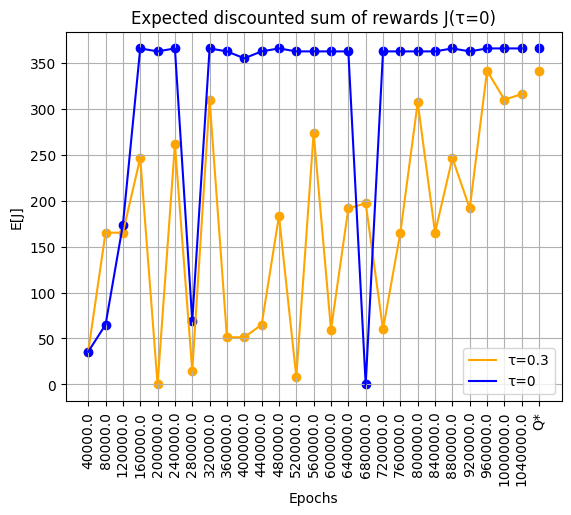

In [12]:
x = np.array([])
y_0 = np.array([])
y = np.array([])

for i, J in enumerate(metrics["J"]):
    y = np.append(y, J)
    y_0 = np.append(y_0, metrics_0["J"][i])
    if i < len(metrics["J"])-1:
        x = np.append(x, (i+1)*status_step)
    else:
        x = np.append(x, "Q*")
x_map = np.array([i for i in range(len(x))])
plt.scatter(x, y, c="orange")
plt.scatter(x, y_0, c="blue")

plt.plot(x[:-1], y[:-1], c="orange", label="τ={}".format(tmdp.tau))
plt.plot(x[:-1], y_0[:-1], c="blue", label="τ=0")
plt.legend(loc="lower right")
plt.xlabel("Epochs")
plt.xticks(rotation=90)
plt.ylabel("E[J]")
plt.title("Expected discounted sum of rewards J(τ=0)")
plt.grid(visible=True)


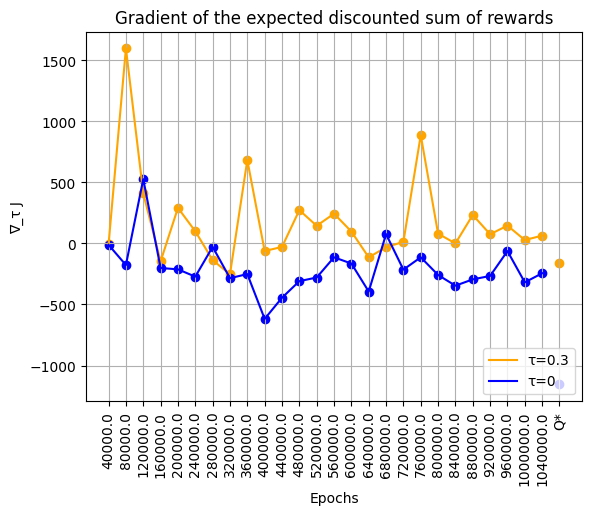

In [13]:
x = np.array([])
y_0 = np.array([])
y = np.array([])

for i, J in enumerate(metrics["grad_J"]):
    y = np.append(y, J)
    y_0 = np.append(y_0, metrics_0["grad_J"][i])
    if i < len(metrics["grad_J"])-1:
        x = np.append(x, (i+1)*status_step)
    else:
        x = np.append(x, "Q*")
x_map = np.array([i for i in range(len(x))])
plt.scatter(x, y, c="orange")
plt.scatter(x, y_0, c="blue")

plt.plot(x[:-1], y[:-1], c="orange", label="τ={}".format(tmdp.tau))
plt.plot(x[:-1], y_0[:-1], c="blue", label="τ=0")
plt.legend(loc="lower right")
plt.xlabel("Epochs")
plt.xticks(rotation=90)
plt.ylabel("∇_τ J")
plt.title("Gradient of the expected discounted sum of rewards")
plt.grid(visible=True)


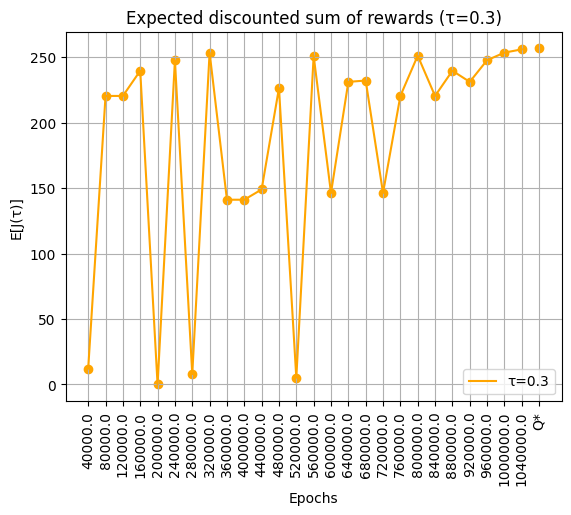

In [14]:
x = np.array([])
y = np.array([])
for i, J in enumerate(metrics["J_tau"]):
    y = np.append(y, J)
    if i < len(metrics["J_tau"])-1:
        x = np.append(x, (i+1)*status_step)
    else:
        x = np.append(x, "Q*")
x_map = np.array([i for i in range(len(x))])
plt.xticks(x_map, x)
plt.scatter(x, y, c="orange")

plt.plot(x[:-1], y[:-1], c="orange", label="τ={}".format(tmdp.tau))
plt.legend(loc="lower right")
plt.xlabel("Epochs")
plt.xticks(rotation=90)
plt.ylabel("E[J(τ)]")
plt.title("Expected discounted sum of rewards (τ={})".format(tmdp.tau))
plt.grid(visible=True)

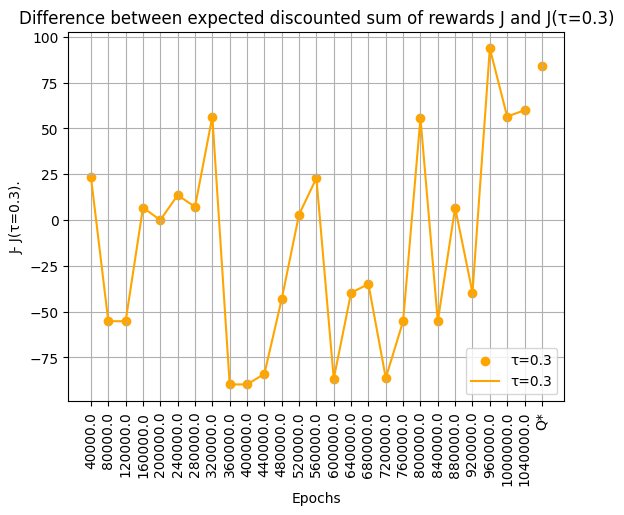

In [15]:
x = np.array([])
y = np.array([])
for i, J in enumerate(metrics["delta_J"]):
    y = np.append(y, J)
    if i < len(metrics["delta_J"])-1:
        x = np.append(x, (i+1)*status_step)
    else:
        x = np.append(x, "Q*")
x_map = np.array([i for i in range(len(x))])
plt.xticks(x_map, x)
plt.scatter(x, y, c="orange", label="τ={}".format(tmdp.tau))
plt.plot(x[:-1], y[:-1], c="orange", label="τ={}".format(tmdp.tau))
plt.xlabel("Epochs")
plt.legend(loc="lower right")
plt.xticks(rotation=90)
plt.ylabel("J- J(τ={}).".format(tmdp.tau))
plt.title("Difference between expected discounted sum of rewards J and J(τ={})".format(tmdp.tau))
plt.grid(visible=True)

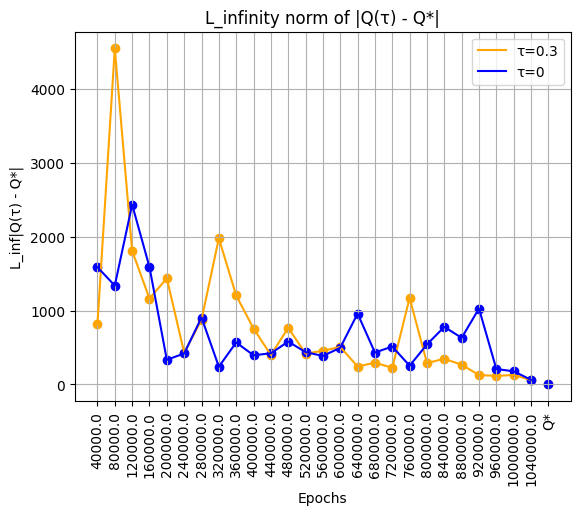

In [16]:
x = np.array([])
y = np.array([])
y_0 = np.array([])
for i, J in enumerate(metrics["delta_Q"]):
    y = np.append(y, J)
    y_0 = np.append(y_0, metrics_0["delta_Q"][i])
    if i < len(metrics["delta_Q"])-1:
        x = np.append(x, (i+1)*status_step)
    else:
        x = np.append(x, "Q*")
x_map = np.array([i for i in range(len(x))])
plt.scatter(x, y, c="orange")
plt.scatter(x, y_0, c="blue")

plt.plot(x[:-1], y[:-1], c="orange", label="τ={}".format(tmdp.tau))
plt.plot(x[:-1], y_0[:-1], c="blue", label="τ=0")
plt.legend(loc="upper right")
plt.xlabel("Epochs")
plt.xticks(rotation=90)
plt.ylabel("L_inf|Q(τ) - Q*|")
plt.title("L_infinity norm of |Q(τ) - Q*|")
plt.grid(visible=True)

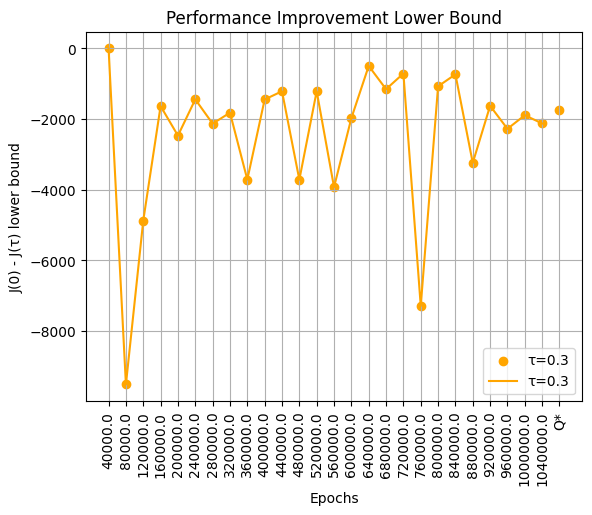

In [17]:
x = np.array([])
y = np.array([])
for i, J in enumerate(metrics["l_bounds"]):
    y = np.append(y, J)
    if i < len(metrics["l_bounds"])-1:
        x = np.append(x, (i+1)*status_step)
    else:
        x = np.append(x, "Q*")
x_map = np.array([i for i in range(len(x))])
plt.scatter(x, y, c="orange", label="τ={}".format(tmdp.tau))
plt.plot(x[:-1], y[:-1], c="orange", label="τ={}".format(tmdp.tau))
plt.legend(loc="lower right")
plt.xlabel("Epochs")
plt.xticks(rotation=90)
plt.ylabel("J(0) - J(τ) lower bound")
plt.title("Performance Improvement Lower Bound")
plt.grid(visible=True)

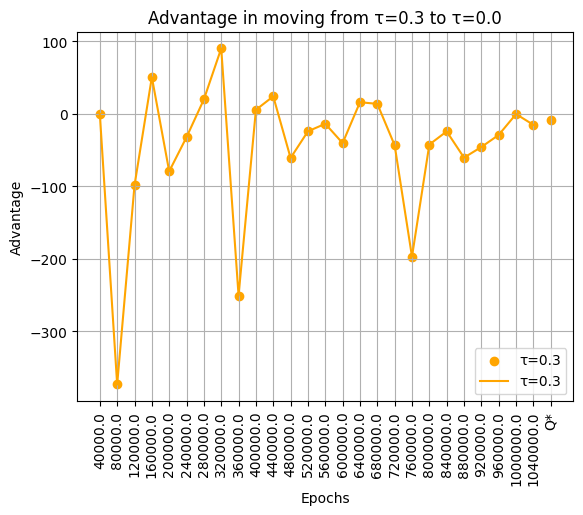

In [18]:
x = np.array([])
y = np.array([])
for i, J in enumerate(metrics["adv_terms"]):
    y = np.append(y, J)
    if i < len(metrics["adv_terms"])-1:
        x = np.append(x, (i+1)*status_step)
    else:
        x = np.append(x, "Q*")
x_map = np.array([i for i in range(len(x))])
plt.scatter(x, y, c="orange", label="τ={}".format(tmdp.tau))
plt.plot(x[:-1], y[:-1], c="orange", label="τ={}".format(tmdp.tau))
plt.legend(loc="lower right")
plt.xlabel("Epochs")
plt.xticks(rotation=90)
plt.ylabel("Advantage")
plt.title("Advantage in moving from τ={} to τ={}".format(tmdp.tau, tau_prime))
plt.grid(visible=True)

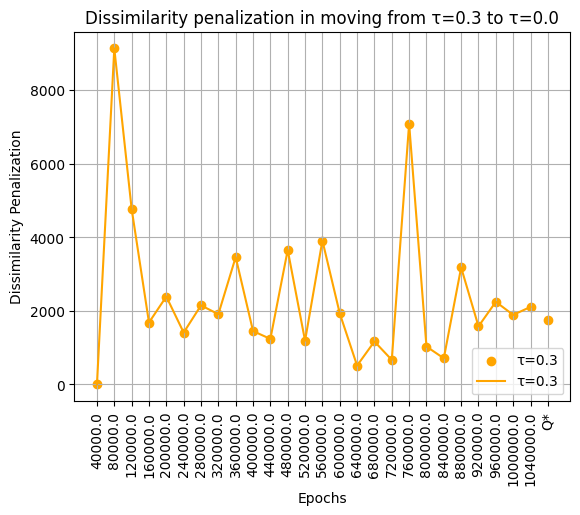

In [19]:
x = np.array([])
y = np.array([])
for i, J in enumerate(metrics["diss_terms"]):
    y = np.append(y, J)
    if i < len(metrics["diss_terms"])-1:
        x = np.append(x, (i+1)*status_step)
    else:
        x = np.append(x, "Q*")
x_map = np.array([i for i in range(len(x))])
plt.scatter(x, y, c="orange", label="τ={}".format(tmdp.tau))
plt.plot(x[:-1], y[:-1], c="orange", label="τ={}".format(tmdp.tau))
plt.legend(loc="lower right")
plt.xlabel("Epochs")
plt.xticks(rotation=90)
plt.ylabel("Dissimilarity Penalization")
plt.title("Dissimilarity penalization in moving from τ={} to τ={}".format(tmdp.tau, tau_prime))
plt.grid(visible=True)

In [20]:
print(Q_star_0)
print(r_s_a_p)
print(r_s_a_xi)

pi_0 = get_policy(Q_star_0)
print(pi_0)
Q_xi_0 = get_q_hat(mdp.xi, r_s_a_xi, mdp.gamma, Q_star_0)
Q_p_0 = get_q_hat(mdp.P_mat, r_s_a_p, mdp.gamma, Q_star_0)
print(Q_xi_0)
print(Q_p_0)

compute_grad_j(pi_0, Q_p_0, Q_xi_0, d, mdp.gamma)


[[ 68.0544467   70.06049679]
 [ 63.05444711  96.0088304 ]
 [ 86.40794736 140.21710219]
 [126.19539197 206.88545394]
 [186.19690854 305.73248103]
 [275.15923293 451.91574319]
 [406.72416887 668.01969924]
 [601.21772931 987.46905542]]
[[  5.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0. 300.]]
[[  0.625   0.   ]
 [  0.      0.   ]
 [  0.      0.   ]
 [  0.      0.   ]
 [  0.      0.   ]
 [  0.      0.   ]
 [  0.      0.   ]
 [  0.    125.   ]]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
[[329.834747 329.209747]
 [329.209747 329.209747]
 [329.209747 329.209747]
 [329.209747 329.209747]
 [329.209747 329.209747]
 [329.209747 329.209747]
 [329.209747 329.209747]
 [329.209747 454.209747]]
[[ 68.05444711  70.06049718]
 [ 63.05444711  96.00883072]
 [ 86.40794736 140.21710248]
 [126.19539197 206.8854542 ]
 [186.19690854 305.73248127]
 [275.15923293 451.91574341]
 [406.72416887 668.01969944]
 [601.21772931 987.46905548]]


-227.43916046261594